In [ ]:
import os
import pandas as pd
import numpy as np
from IPython.display import Image 
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers  import Conv2D, Dense, MaxPooling2D, Dropout, Flatten
from sklearn.model_selection import train_test_split
import plotly.express as px

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Dec 21 16:44:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    25W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pwd

/content


In [ ]:
from zipfile import ZipFile
with ZipFile('/content/drive/MyDrive/capstone_project/All-Age-Faces Dataset.zip')as z:
  z.extractall()
print('Extracted Data')
!pwd

Extracted Data
/content


In [ ]:
os.chdir('/content/All-Age-Faces Dataset/original images')
!pwd

/content/All-Age-Faces Dataset/original images


In [ ]:
face_cascade = cv2.CascadeClassifier('/content/frontalface.xml')

In [ ]:
df_1 = pd.read_csv('/content/drive/MyDrive/capstone_project/train_dataset.csv')
!pwd

/content/All-Age-Faces Dataset/original images


In [ ]:
df_2 = pd.read_csv('/content/drive/MyDrive/capstone_project/val_dataset.csv')
!pwd

/content/All-Age-Faces Dataset/original images


In [ ]:
frames = [df_1,df_2]
df = pd.concat(frames)
display(df)

,Column1,Column2
0,00000A02.jpg,0
1,00002A02.jpg,0
2,00004A02.jpg,0
3,00006A02.jpg,0
4,00008A02.jpg,0
...,...,...
6680,13312A80.jpg,1
6681,13314A80.jpg,1
6682,13316A80.jpg,1
6683,13318A80.jpg,1


In [ ]:
df = df.sort_values(by = ['Column1'])
display(df)

,Column1,Column2
0,00000A02.jpg,0
0,00001A02.jpg,0
1,00002A02.jpg,0
1,00003A02.jpg,0
2,00004A02.jpg,0
...,...,...
6634,13317A80.jpg,1
6683,13318A80.jpg,1
6635,13319A80.jpg,1
6684,13320A80.jpg,1


In [ ]:
df.reset_index (inplace = True,drop = True)
df.head()

,Column1,Column2
0,00000A02.jpg,0
1,00001A02.jpg,0
2,00002A02.jpg,0
3,00003A02.jpg,0
4,00004A02.jpg,0


In [ ]:
df = df.rename(columns = {'Column1':'name','Column2':'gender'})
df.head()

,name,gender
0,00000A02.jpg,0
1,00001A02.jpg,0
2,00002A02.jpg,0
3,00003A02.jpg,0
4,00004A02.jpg,0


In [ ]:
df['gender'].value_counts()

0    7381
1    5941
Name: gender, dtype: int64

In [ ]:
def age(x):
  return x[6:8]

In [ ]:
df['age'] = df['name'].apply(age) 
df.tail()

,name,gender,age
13317,13317A80.jpg,1,80
13318,13318A80.jpg,1,80
13319,13319A80.jpg,1,80
13320,13320A80.jpg,1,80
13321,13321A80.jpg,1,80


In [ ]:

source = '/content/All-Age-Faces Dataset/original images'
df['path'] = df['name'].apply(lambda x : os.path.join(source,x))
df.head()

,name,gender,age,path
0,00000A02.jpg,0,02,/content/All-Age-Faces Dataset/original images...
1,00001A02.jpg,0,02,/content/All-Age-Faces Dataset/original images...
2,00002A02.jpg,0,02,/content/All-Age-Faces Dataset/original images...
3,00003A02.jpg,0,02,/content/All-Age-Faces Dataset/original images...
4,00004A02.jpg,0,02,/content/All-Age-Faces Dataset/original images...


In [ ]:
#d = {'name': os.listdir(source)}
#path = pd.DataFrame(data=d)
#path.head()

In [ ]:
#df = pd.merge(df, path, on = ['name'])

In [ ]:
print(df.shape)


(13322, 4)


In [ ]:
df.describe()

,gender
count,13322.000000
mean,0.445954
std,0.497089
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [ ]:
fig = px.histogram(df,'age',
    color="gender")
fig.show()

In [ ]:
df.dtypes

name      object
gender     int64
age       object
path      object
dtype: object

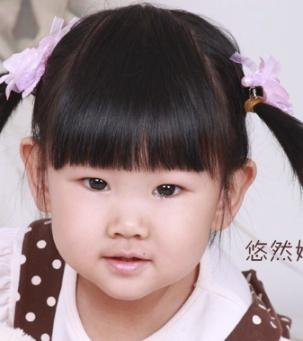

In [ ]:
img = cv2.imread(df['name'][1])
display(Image(df['name'][1]))

In [ ]:
def adjusted_detect_face(img):
     
    face_img = img.copy()
    
    face_rect = face_cascade.detectMultiScale(face_img,scaleFactor = 1.2,minNeighbors = 1, minSize = (50,50),flags = cv2.CASCADE_SCALE_IMAGE)
     
    for (x, y, w, h) in face_rect:
        cv2.rectangle(face_img, (x, y),(x + w, y + h), (255, 255, 255), 10)
        crop=face_img[y:y+h,x:x+w]
        #print(lst)      
    return crop

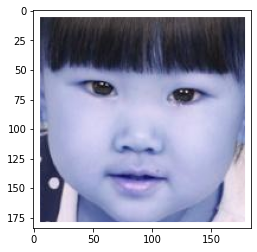

In [ ]:
face = adjusted_detect_face(img)
plt.imshow(face)

In [ ]:
def prep_data1(df):
  l = df.shape[0]
  img_crp, ages, genders = [],[],[]
  for j in range(l):
    path = df['name'].iloc[j]
    img = cv2.imread(df['name'][j])
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    copy = img.copy() 
    face_rect = face_cascade.detectMultiScale(copy,scaleFactor = 1.5,minNeighbors = 1, minSize = (3,3))
    if len(face_rect) == 1:
      for i in face_rect:
        face_img1=cv2.rectangle(copy, (i[0], i[1]),(i[0] + i[2], i[1] + i[3]), (255, 255, 255), 10)
        img_c = (copy[i[1]:i[1] + i[3], i[0]:i[2] + i[0]])
        img_c = cv2.resize(img_c,dsize=(64,64))
        img_c = (np.reshape(img_c,(64,64,3,1)))
        img_c = img_c/225.
        img_crp.append(img_c)
        ages.append(df['age'].iloc[j])
        #ages.append([df['age'].iloc[j],int(df['age'].iloc[j])])
        genders.append([df['gender'].iloc[j]])
  return img_crp,ages,genders

In [ ]:
x,y,z = prep_data1(df)

In [ ]:
x[20].dtype

dtype('float64')

In [ ]:
len(x),len(y),len(z)

(10020, 10020, 10020)

In [ ]:
a = np.array([int(x) for x in y])

In [ ]:
type(a)

numpy.ndarray

In [ ]:
a[0],a.shape

(2, (10020,))

In [ ]:
z[0]

[0]

In [ ]:
"""t = np.random.randint(df.shape[0])
gender_map={1:'Male',0:'Female'}
cv2_imshow(x[t])
print('Age:{} , Gender:{}'.format(y[t],gender_map[z[t]]))
x[t].shape"""

"t = np.random.randint(df.shape[0])\ngender_map={1:'Male',0:'Female'}\ncv2_imshow(x[t])\nprint('Age:{} , Gender:{}'.format(y[t],gender_map[z[t]]))\nx[t].shape"

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
z = enc.fit_transform(z).toarray()
z[0],z[0].shape

(array([1., 0.]), (2,))

In [ ]:
z[0].shape

(2,)

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(x,a,test_size=0.2,stratify=a,random_state=42)
x_train = np.array(x_train)
x_val = np.array(x_val)
x_train.shape,x_val.shape,y_train.shape,y_val.shape
#len(x_train),len(x_val),len(y_train),len(y_val)

((8016, 64, 64, 3, 1), (2004, 64, 64, 3, 1), (8016,), (2004,))

In [ ]:
os.chdir('/content')
print(os.getcwd())
os.mkdir('check_points')
os.chdir('check_points')
os.mkdir('age')
os.mkdir('gender')
!pwd

/content
/content/check_points


In [ ]:
checkpoint_path_age='/content/check_points/age/best_model-{epoch:02d}-{val_loss:.2f}.hdf5'

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                 factor=0.5, patience=4, 
                                                 verbose=1, mode='max', 
                                                 min_lr=0.000001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=42,
                                              verbose=1)

model_checkpoint_age = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_age, 
                                                      save_weights_only=True, 
                                                      monitor='val_loss', 
                                                      mode='max', 
                                                      save_best_only=True)

In [ ]:
model = keras.models.Sequential(name='network_age')
model.add(Conv2D(16, kernel_size=(3, 3),activation='relu',input_shape=(64,64,3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(Dense(128, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(96,activation = 'relu'))
#model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(1,activation = None))

In [ ]:
model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001), loss = 'mae', metrics = ['mae'])
model.summary()

Model: "network_age"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 12544)             

In [ ]:
history=model.fit(x_train,y_train,validation_data=(x_val,y_val),batch_size=64,epochs=1100,callbacks=[early_stop, model_checkpoint_age, reduce_lr],verbose=1)#

Epoch 1/1100
126/126 [==============================] - 11s 19ms/step - loss: 20.5995 - mae: 20.5995 - val_loss: 22.2496 - val_mae: 22.2496 - lr: 0.0010
Epoch 2/1100
126/126 [==============================] - 2s 14ms/step - loss: 12.3245 - mae: 12.3245 - val_loss: 15.1084 - val_mae: 15.1084 - lr: 0.0010
Epoch 3/1100
126/126 [==============================] - 2s 14ms/step - loss: 11.1233 - mae: 11.1233 - val_loss: 19.4789 - val_mae: 19.4789 - lr: 0.0010
Epoch 4/1100
126/126 [==============================] - 2s 13ms/step - loss: 10.4222 - mae: 10.4222 - val_loss: 11.0852 - val_mae: 11.0852 - lr: 0.0010
Epoch 5/1100
121/126 [===========================>..] - ETA: 0s - loss: 9.7753 - mae: 9.7753
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
126/126 [==============================] - 2s 12ms/step - loss: 9.7907 - mae: 9.7907 - val_loss: 11.9473 - val_mae: 11.9473 - lr: 0.0010
Epoch 6/1100
126/126 [==============================] - 2s 12ms/step - loss: 9.0112 -

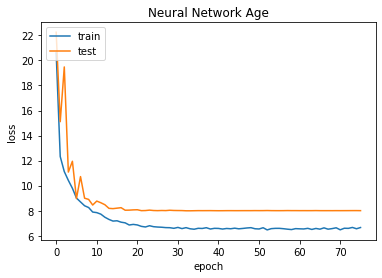

In [ ]:
import matplotlib.pyplot as plt
def plot_stats(history_logs):
  # summarize history for loss
  plt.plot(history_logs.history['loss'])
  plt.plot(history_logs.history['val_loss'])
  plt.title('Neural Network Age')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
plot_stats(history)

In [ ]:
64,1000
256,100

(256, 100)

In [ ]:
from sklearn.model_selection import train_test_split
x1_train,x1_val,z_train,z_val=train_test_split(x,z,test_size=0.2,stratify=z,random_state=42)
x1_train = np.array(x1_train)
x1_val = np.array(x1_val)
z_train = np.array(z_train)
z_val = np.array(z_val)
x1_train.shape,x1_val.shape,z_train.shape,z_val.shape
#len(x_train),len(x_val),len(y_train),len(y_val)

((8016, 64, 64, 3, 1), (2004, 64, 64, 3, 1), (8016, 2), (2004, 2))

In [ ]:
checkpoint_path_gender='/content/check_points/gender/best_model-{epoch:02d}-{val_loss:.2f}.hdf5'

In [ ]:
reduce_lr_gender = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', 
                                                 factor=0.5, patience=4, 
                                                 verbose=1, mode='max', 
                                                 min_lr=0.000001)

early_stop_gender = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=42,
                                              verbose=1)

model_checkpoint_gender = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_gender, 
                                                      save_weights_only=True, 
                                                      monitor='val_acc', 
                                                      mode='max', 
                                                      save_best_only=True)

In [ ]:
from keras.backend import categorical_crossentropy
model_C = keras.models.Sequential(name='network_gender')
model_C.add(Conv2D(16, kernel_size=(3, 3),activation='relu',input_shape=(64,64,3)))
model_C.add(Conv2D(32, (3, 3), activation='relu'))
model_C.add(MaxPooling2D(pool_size=(2, 2)))
model_C.add(Conv2D(64, (3, 3), activation='relu'))
model_C.add(MaxPooling2D(pool_size=(2, 2)))
model_C.add(tf.keras.layers.Flatten())
model_C.add(Dense(128, activation='relu'))
model_C.add(tf.keras.layers.BatchNormalization())
model_C.add(Dropout(0.5))
model_C.add(Dense(96,activation = 'relu'))
#model.add(tf.keras.layers.BatchNormalization())
model_C.add(Dense(2,activation = 'sigmoid'))

In [ ]:
model_C.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001), loss = 'categorical_crossentropy', metrics = ['acc'])
model_C.summary()

Model: "network_gender"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 62, 62, 16)        448       
                                                                 
 conv2d_13 (Conv2D)          (None, 60, 60, 32)        4640      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 12544)          

In [ ]:
history_c= model_C.fit(x1_train,z_train,validation_data=(x1_val,z_val),batch_size=64,epochs=200,callbacks=[early_stop_gender, model_checkpoint_gender, reduce_lr_gender],verbose=1)#

Epoch 1/200
126/126 [==============================] - 3s 16ms/step - loss: 0.5269 - acc: 0.7373 - val_loss: 0.5283 - val_acc: 0.7769 - lr: 0.0010
Epoch 2/200
126/126 [==============================] - 2s 13ms/step - loss: 0.4190 - acc: 0.8090 - val_loss: 0.4668 - val_acc: 0.7730 - lr: 0.0010
Epoch 3/200
126/126 [==============================] - 2s 13ms/step - loss: 0.3765 - acc: 0.8347 - val_loss: 0.5989 - val_acc: 0.6966 - lr: 0.0010
Epoch 4/200
126/126 [==============================] - 2s 13ms/step - loss: 0.3440 - acc: 0.8537 - val_loss: 0.3418 - val_acc: 0.8418 - lr: 0.0010
Epoch 5/200
126/126 [==============================] - 2s 13ms/step - loss: 0.3136 - acc: 0.8660 - val_loss: 0.5781 - val_acc: 0.7730 - lr: 0.0010
Epoch 6/200
126/126 [==============================] - 2s 13ms/step - loss: 0.2862 - acc: 0.8789 - val_loss: 0.3192 - val_acc: 0.8623 - lr: 0.0010
Epoch 7/200
126/126 [==============================] - 2s 13ms/step - loss: 0.2756 - acc: 0.8809 - val_loss: 0.3260 - 

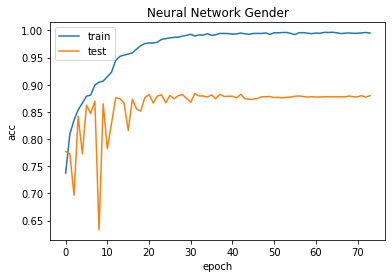

In [ ]:
import matplotlib.pyplot as plt
def plot_stats(history_logs):
  # summarize history for loss
  plt.plot(history_logs.history['acc'])
  plt.plot(history_logs.history['val_acc'])
  plt.title('Neural Network Gender')
  plt.ylabel('acc')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
plot_stats(history_c)

In [ ]:
#32,100
#64,50
#128,75

**TESTING**

In [ ]:
os.chdir('/content/test')

In [ ]:
!pwd

/content/test


In [ ]:
from zipfile import ZipFile
with ZipFile('/content/Test Images.zip')as z:
  z.extractall()
print('Extracted Data')
!pwd

Extracted Data
/content/test


In [ ]:
source = os.listdir('/content/test/Test Images')
sorted(source)

['0333A00_28_1.jpg',
 '0333A01_27_0.jpg',
 '0333A11_26_1.jpeg',
 '0333H02_25_1.jpg',
 '0333K10_27_0.jpeg',
 '0333M12_30_1.jpg',
 '0333N03_27_1.jpg',
 '0333P04_65_1.jpg',
 '0333R05_24_1.jpg',
 '0333R13_27_1.jpeg',
 '0333S06_22_0.jpg',
 '0333S07_24_1.jpg',
 '0333S08_27_1.jpeg',
 '0333S09_53_1.jpg']

In [ ]:
d_t = {'col1': source}
df_t = pd.DataFrame(data = d_t)

In [ ]:
df_t

,col1
0,0333A11_26_1.jpeg
1,0333S09_53_1.jpg
2,0333K10_27_0.jpeg
3,0333N03_27_1.jpg
4,0333S06_22_0.jpg
5,0333S08_27_1.jpeg
6,0333A01_27_0.jpg
7,0333H02_25_1.jpg
8,0333S07_24_1.jpg
9,0333A00_28_1.jpg


In [ ]:
source_t = '/content/test/Test Images'
df_t['path'] = df_t['col1'].apply(lambda x : os.path.join(source_t,x))
df_t.head()

,col1,path
0,0333A11_26_1.jpeg,/content/test/Test Images/0333A11_26_1.jpeg
1,0333S09_53_1.jpg,/content/test/Test Images/0333S09_53_1.jpg
2,0333K10_27_0.jpeg,/content/test/Test Images/0333K10_27_0.jpeg
3,0333N03_27_1.jpg,/content/test/Test Images/0333N03_27_1.jpg
4,0333S06_22_0.jpg,/content/test/Test Images/0333S06_22_0.jpg


In [ ]:
len(df_t['col1'][10])#[-5]

16

In [ ]:
def gender(x):
      if len(x) == 16:
        return x[-5]
      else:
        return x[-6]

In [ ]:
df_t['gender'] = df_t['col1'].apply(gender)
df_t

,col1,path,gender
0,0333A11_26_1.jpeg,/content/test/Test Images/0333A11_26_1.jpeg,1
1,0333S09_53_1.jpg,/content/test/Test Images/0333S09_53_1.jpg,1
2,0333K10_27_0.jpeg,/content/test/Test Images/0333K10_27_0.jpeg,0
3,0333N03_27_1.jpg,/content/test/Test Images/0333N03_27_1.jpg,1
4,0333S06_22_0.jpg,/content/test/Test Images/0333S06_22_0.jpg,0
5,0333S08_27_1.jpeg,/content/test/Test Images/0333S08_27_1.jpeg,1
6,0333A01_27_0.jpg,/content/test/Test Images/0333A01_27_0.jpg,0
7,0333H02_25_1.jpg,/content/test/Test Images/0333H02_25_1.jpg,1
8,0333S07_24_1.jpg,/content/test/Test Images/0333S07_24_1.jpg,1
9,0333A00_28_1.jpg,/content/test/Test Images/0333A00_28_1.jpg,1


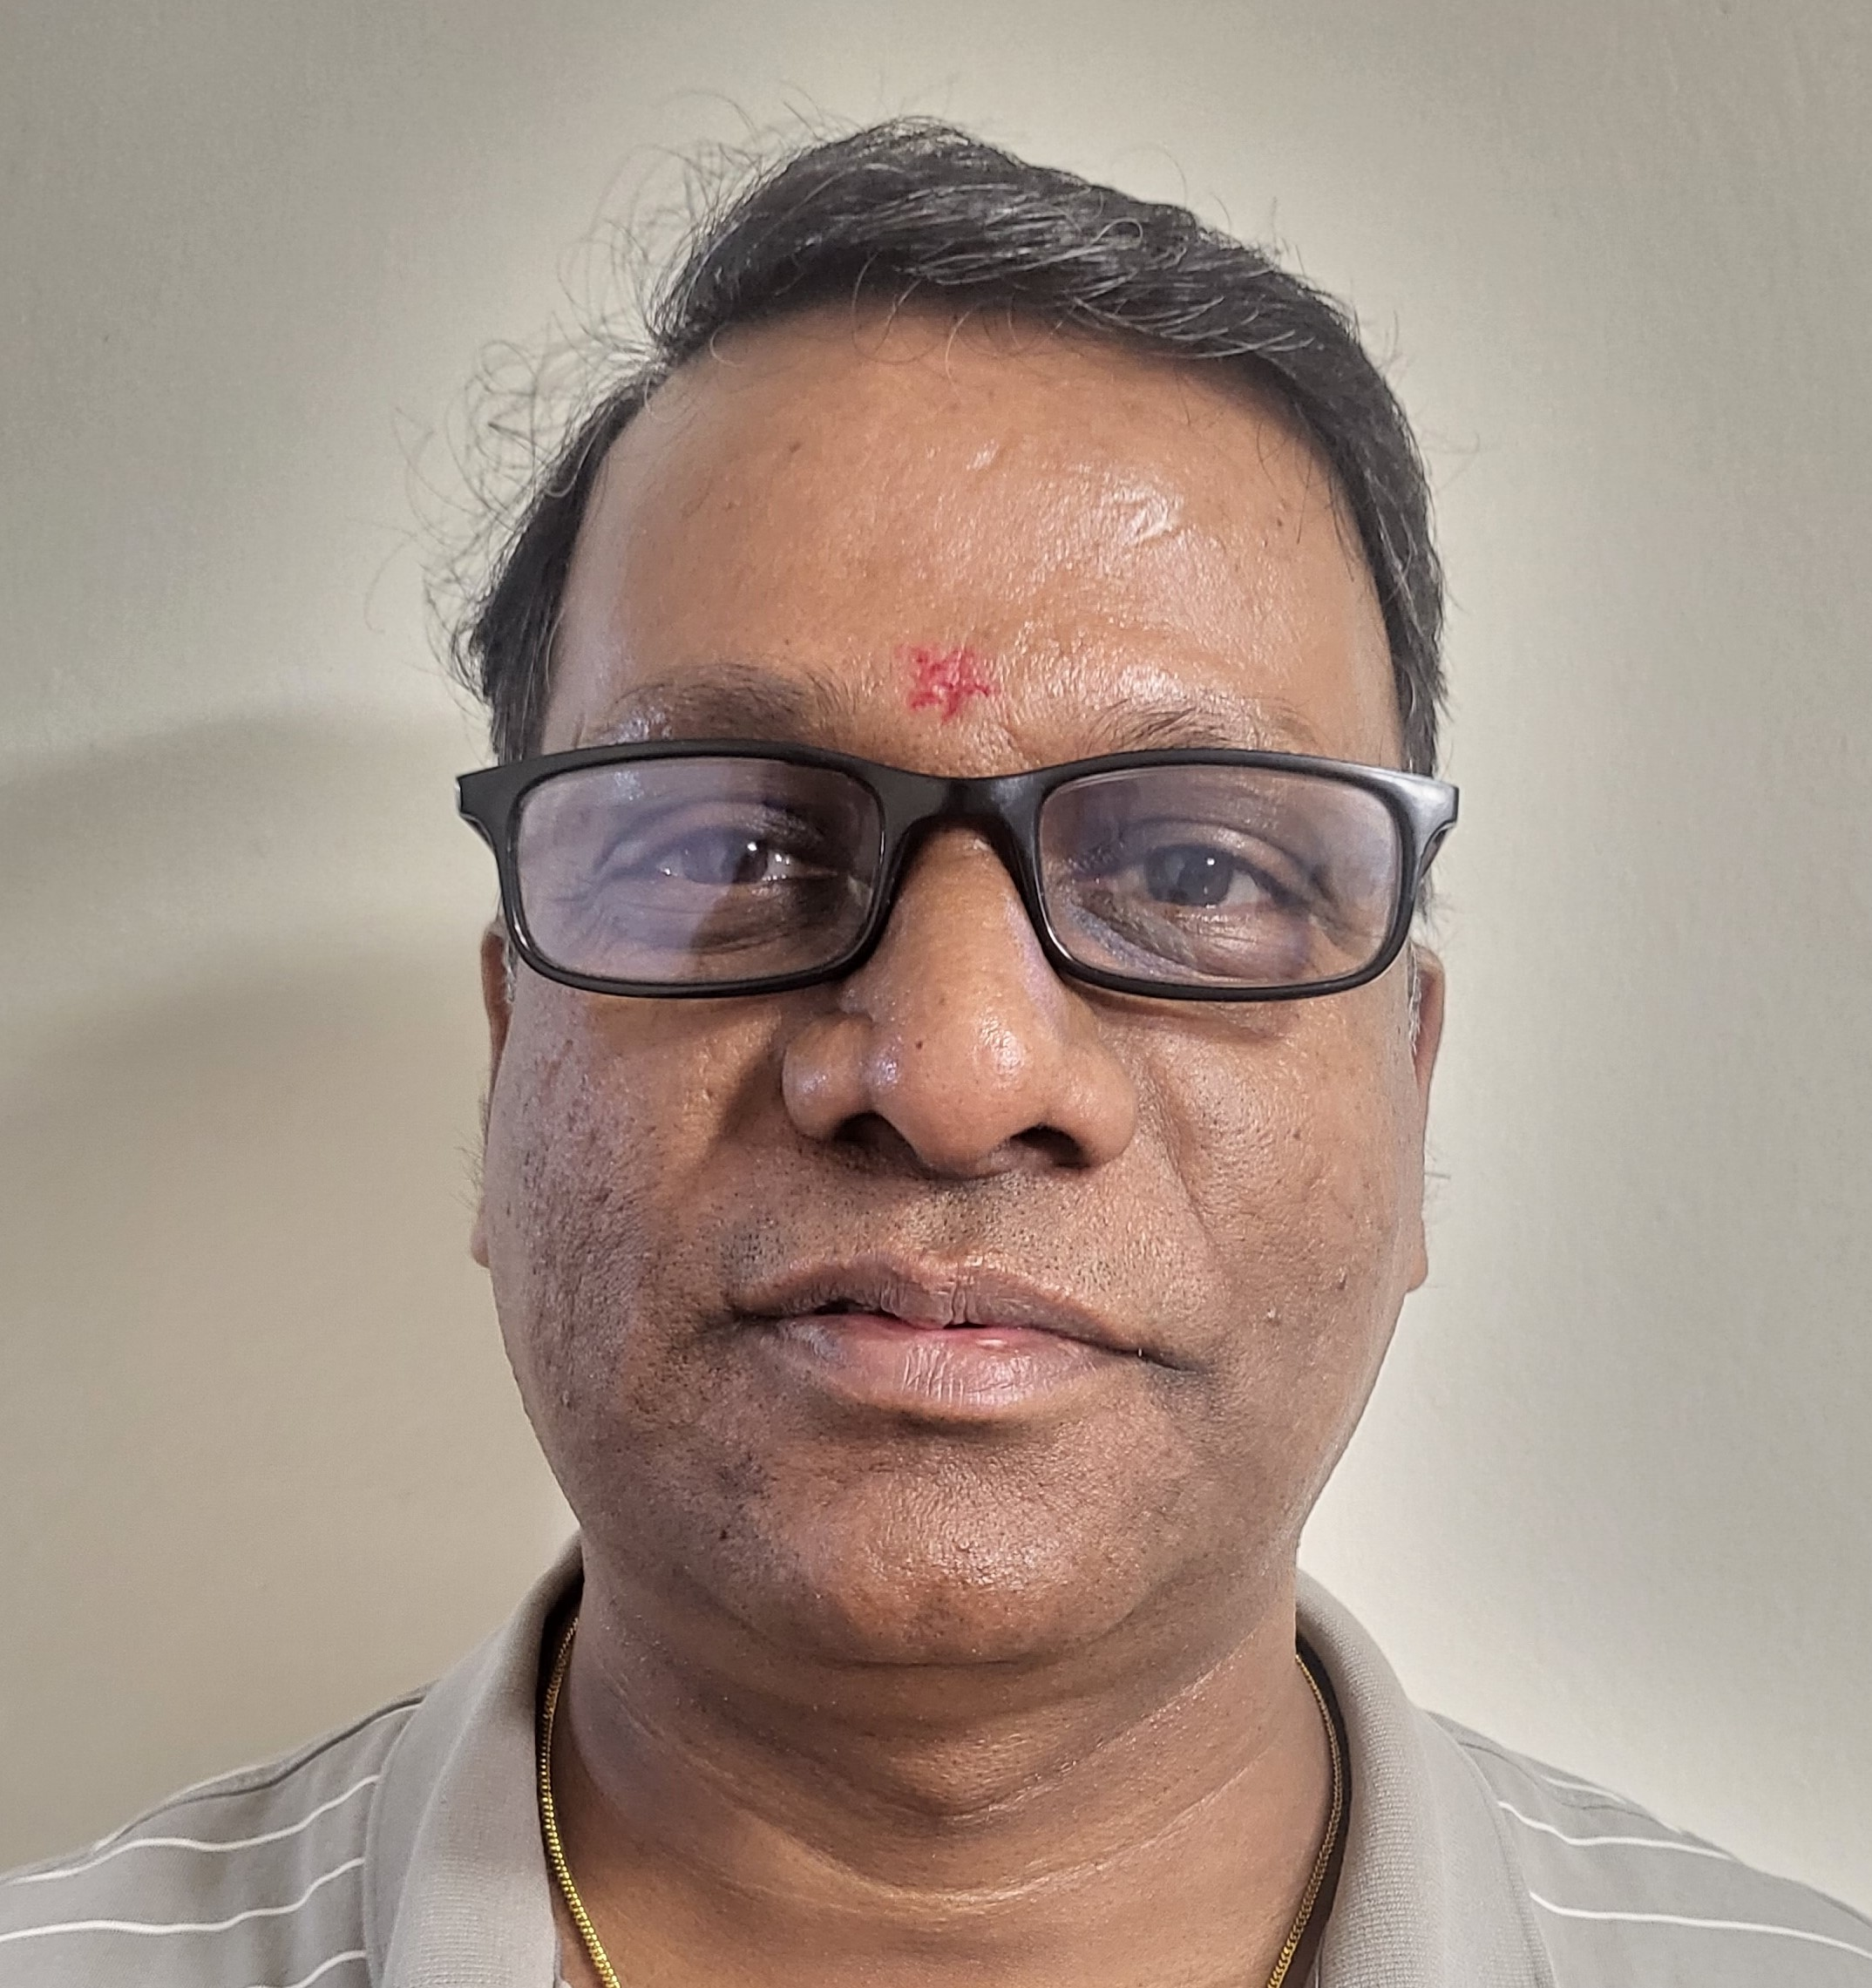

In [ ]:
display(Image(df_t['path'][1]))

In [ ]:
l = df_t.shape[0]
img_crop,gender_t,name = [],[],[]
for j in range(l):
   path = df_t['col1'].iloc[j]
   pic = cv2.imread(df_t['path'][j])
   #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
   copy = pic.copy() 
   face_rect = face_cascade.detectMultiScale(copy,scaleFactor = 1.5,minNeighbors = 1, minSize = (3,3))
   if len(face_rect) == 1:
     for i in face_rect:
       face_img1=cv2.rectangle(copy, (i[0], i[1]),(i[0] + i[2], i[1] + i[3]), (255, 255, 255), 10)
       pic = (copy[i[1]:i[1] + i[3], i[0]:i[2] + i[0]])
       pic = cv2.resize(pic,dsize=(64,64))
       pic = (np.reshape(pic,(64,64,3,1)))
       pic = pic/225.
       img_crop.append(pic)
       name.append([df_t['col1'].iloc[j]])
       gender_t.append([df_t['gender'].iloc[j]])


In [ ]:
len(img_crop),(gender_t)

(8, [['1'], ['1'], ['0'], ['0'], ['1'], ['1'], ['1'], ['1']])

In [ ]:
name

[['0333S09_53_1.jpg'],
 ['0333N03_27_1.jpg'],
 ['0333S06_22_0.jpg'],
 ['0333A01_27_0.jpg'],
 ['0333H02_25_1.jpg'],
 ['0333A00_28_1.jpg'],
 ['0333R13_27_1.jpeg'],
 ['0333P04_65_1.jpg']]

In [ ]:
x_t = np.array(img_crop)

In [ ]:
pred_age = model.predict(x_t)
pred_age

1/1 [==============================] - 0s 182ms/step


array([[38.263447],
       [28.968016],
       [34.637104],
       [25.760563],
       [26.969387],
       [27.747952],
       [26.126293],
       [53.795174]], dtype=float32)

In [ ]:
pre_gender = model_C.predict(x_t)

1/1 [==============================] - 0s 79ms/step


In [ ]:
pre_gender = pre_gender.argmax(axis = 1)
pre_gender

array([1, 1, 0, 0, 1, 0, 1, 0])

In [ ]:
age_t = [40.319675,32.156544,35.722286,32.210968,39.315716,70.2662,45.15705,38.95553]
gender_t = [1, 1, 0, 0, 1, 0, 1, 0]

In [ ]:
total = {'name':name,'pre_age':age_t,'pred_gender': gender_t}
output_df = pd.DataFrame(data = total)
output_df

,name,pre_age,pred_gender
0,[0333S09_53_1.jpg],40.319675,1
1,[0333N03_27_1.jpg],32.156544,1
2,[0333S06_22_0.jpg],35.722286,0
3,[0333A01_27_0.jpg],32.210968,0
4,[0333H02_25_1.jpg],39.315716,1
5,[0333A00_28_1.jpg],70.266200,0
6,[0333R13_27_1.jpeg],45.157050,1
7,[0333P04_65_1.jpg],38.955530,0


In [ ]:
def demo(path):
  pic = []
  #gender_dict = {1:'Male', 0 : 'Female'}
  img = cv2.imread(path)
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  copy = img.copy() 
  face_rect = face_cascade.detectMultiScale(copy,scaleFactor = 1.5,minNeighbors = 1, minSize = (3,3))
  if len(face_rect) == 1:
    for i in face_rect:
      face_img1=cv2.rectangle(copy, (i[0], i[1]),(i[0] + i[2], i[1] + i[3]), (255, 255, 255), 10)
      x,y,w,h = i[0],i[1],i[2], i[3]
      img_c = (copy[i[1]:i[1] + i[3], i[0]:i[2] + i[0]])
      img_c = cv2.resize(img_c,dsize=(64,64))
      img_c = (np.reshape(img_c,(1,64,64,3)))
      img_c = img_c/225.
      pic.append(img_c)
  age = model.predict(pic)
  pre_gender = model_C.predict(pic)
  pre_gender = pre_gender.argmax(axis = 1)
  cv2.rectangle(img, (x, y), (x + w, y + h), (0,255,0), 10)
  text = "Age: {:.2f}, Gender: {}".format(age[0,0], pre_gender[0])
  #cv2.putText(img, text, (x,y+h), cv2.FONT_HERSHEY_SIMPLEX,1,(255,0,0), 20)
  plt.imshow(img)
  print(text)

1/1 [==============================] - 0s 15ms/step
Age: 26.97, Gender: Male


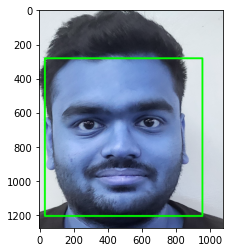

In [ ]:
demo(df_t['path'][7])